# Potential conflicts in transatlantic flights #

In [2]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap
import conflict
import analysis
import os
import networkx as nx
import tools
import matplotlib.backends.backend_pdf
import matplotlib.backends.backend_pgf
import seaborn

In [3]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

mindistance = 30.0
mintime = 21
delayPerConflict = 0
dthreshold = 3
maxDepartDelay = 18

name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
rawPointConflictFile = '%s.%s.rawPointConflicts.csv' % (inputFile, name)
pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)       
parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
flights2ConflictsFile = "%s.%s.flights2Conflicts_delay%03i_thres%03i_depart%03i.h5" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
reducedPointConflictFile = "%s.%s.reducedPointConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
reducedParallelConflictFile = "%s.%s.reducedParallelConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)

rawPointConflicts = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
pointConflicts = pd.read_csv(pointConflictFile, index_col='conflictIndex')
parallelConflicts = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
flights2Conflicts = pd.read_hdf(flights2ConflictsFile, 'flights2Conflicts')
reducedPointConflicts = pd.read_csv(reducedPointConflictFile, index_col='conflictIndex')
reducedParallelConflicts= pd.read_csv(reducedParallelConflictFile, index_col='parallelConflict')        

In [4]:
%matplotlib inline

In [5]:
NRawPointConflicts = rawPointConflicts.shape[0]
NPointConflicts = pointConflicts.shape[0]
NParallelConflicts = len(parallelConflicts.index.unique())
NFlights = len(set(list(pointConflicts.flight1.values)) | set(list(pointConflicts.flight2.values)) | set(list(parallelConflicts.flight1.values)) | set(list(parallelConflicts.flight2.values)))
print NRawPointConflicts, "raw potential conflicts"
print NPointConflicts, "potential point conflicts"
print NParallelConflicts, "potential parallel conflicts"
print NPointConflicts + NParallelConflicts, "total potential conflicts"
print NFlights, "flights involved"

1728811 raw potential conflicts
38 potential point conflicts
3625 potential parallel conflicts
3663 total potential conflicts
889 flights involved


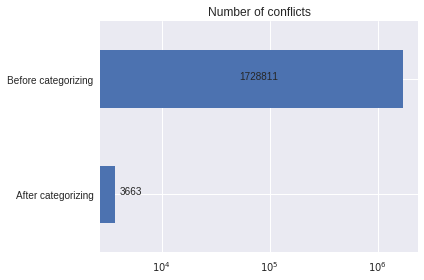

In [6]:
#matplotlib.rcParams.update(rcp)
data = [NRawPointConflicts, NPointConflicts + NParallelConflicts]
labels = ['Before categorizing', 'After categorizing']
pltData = pd.Series(dict(zip(labels, data)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
pltData.plot(kind='barh', ax = ax)
ax.set_xscale('log')
ax.set_title('Number of conflicts')
ax.text(0.03 * data[0], 1, '%i' % data[0])
ax.text(1.1 * data[1], 0, '%i' % data[1])
plt.tight_layout()

pdf = matplotlib.backends.backend_pdf.PdfPages('number_of_conflicts.pdf');
pdf.savefig(figure=fig);
pdf.close();
#matplotlib.rcParams = rcParams

In [7]:
G = analysis.getConflictGraph(reducedPointConflicts, reducedParallelConflicts)
components = nx.connected_component_subgraphs(G)
sortedComponents = sorted(list(components), key=lambda x: len(x.nodes()))
print  len(sortedComponents), "connected components"

51 connected components


In [8]:
tw = []
nf = []
nc = []
for cc in sortedComponents:
    nf.append(cc.number_of_nodes())
    nc.append(cc.number_of_edges())
    if nx.is_chordal(cc):
        tw.append(nx.chordal_graph_treewidth(cc))
    else:
        tw.append(np.nan)
graphdata = pd.DataFrame({'treewidth': tw, 'numberOfFlights': nf, 'numberOfConflicts': nc})

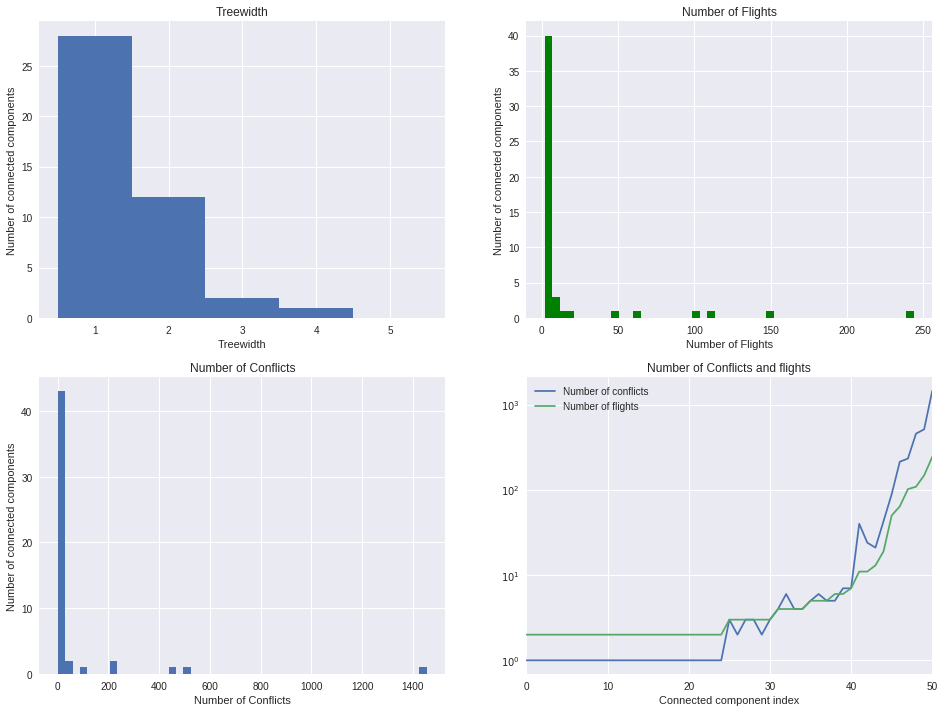

In [9]:
     
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 2, 1)
graphdata['treewidth'].hist(ax=ax, bins=[0.5 + i for i in range(int(graphdata['treewidth'].max()))])
ax.grid('on')
ax.set_title('Treewidth')
ax.set_ylabel('Number of connected components')
ax.set_xlabel('Treewidth');

ax = fig.add_subplot(2, 2, 2)
graphdata['numberOfFlights'].hist(ax=ax, bins=50, color='g')
ax.set_title('Number of Flights')
ax.set_xlabel('Number of Flights')
ax.set_ylabel('Number of connected components');

ax = fig.add_subplot(2, 2, 3)
graphdata['numberOfConflicts'].hist(ax=ax, bins=50)
ax.set_title('Number of Conflicts')
ax.set_xlabel('Number of Conflicts')
ax.set_ylabel('Number of connected components');

ax = fig.add_subplot(2, 2, 4)
graphdata['numberOfConflicts'].plot(ax=ax, label='Number of conflicts')
graphdata['numberOfFlights'].plot(ax=ax, label='Number of flights')
ax.grid('on')
ax.legend()
ax.set_yscale('log')
ax.set_title('Number of Conflicts and flights')
ax.set_xlabel('Connected component index');

pdf = matplotlib.backends.backend_pdf.PdfPages('conflict_graph_connected_components_analysis.pdf');
pdf.savefig(figure=fig);
pdf.close();

In [30]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

mindistance = 30.0

delayPerConflict = 0
dthreshold = 3
Nbefore = {}
Nafter = {}
for maxDepartDelay in [6, 9, 12, 15, 18, 24, 36, 48, 60]:
    mintime = dthreshold + maxDepartDelay


    name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
    rawPointConflictFile = '%s.%s.rawPointConflicts.csv' % (inputFile, name)
    pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)       
    parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
    flights2ConflictsFile = "%s.%s.flights2Conflicts_delay%03i_thres%03i_depart%03i.h5" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
    reducedPointConflictFile = "%s.%s.reducedPointConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
    reducedParallelConflictFile = "%s.%s.reducedParallelConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)


    rawPointConflicts = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
    reducedPointConflicts = pd.read_csv(reducedPointConflictFile, index_col='conflictIndex')
    reducedParallelConflicts= pd.read_csv(reducedParallelConflictFile, index_col='parallelConflict')
    
    Nbefore[maxDepartDelay] = len(rawPointConflicts)
    Nafter[maxDepartDelay] = len(reducedPointConflicts) + len(reducedParallelConflicts.index.unique())

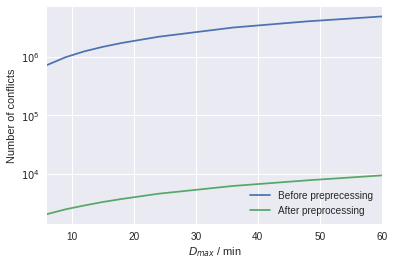

In [60]:

pltData = pd.DataFrame([Nbefore, Nafter])
pltData = pltData.swapaxes(0, 1)
pltData.columns = ['Before preprecessing', 'After preprocessing']
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
pltData.plot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Number of conflicts')
ax.set_xlabel('$D_{max}$ / min')
pdf = matplotlib.backends.backend_pdf.PdfPages('paperpics/preprocessing_reduction_number_of_conflicts.pdf');
pdf.savefig(figure=fig);
pdf.close();

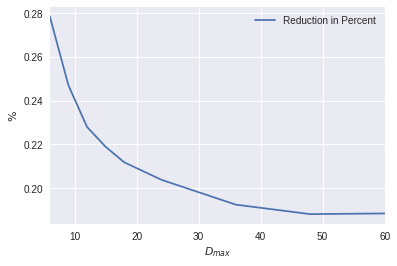

In [58]:

pltData = pd.DataFrame([Nbefore, Nafter])
pltData = pltData.swapaxes(0, 1)
pltData.columns = ['Before preprocessing', 'After preprocessing']
pltData['Reduction in Percent'] =  100.0 * pltData['After preprocessing'] / pltData['Before preprocessing']
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

pltData['Reduction in Percent'].plot()
ax.set_xlabel('$D_{max}$')
ax.set_ylabel('$\%$')
ax.legend()
pdf = matplotlib.backends.backend_pdf.PdfPages('ratio_number_of_conflicts.pdf');
pdf.savefig(figure=fig);
pdf.close();